MNIST 손글씨 데이터로 CNN , svm비교

In [156]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping

from preprocess import get_hinge_features
from preprocess import get_chain_code_features
from preprocess import preprocessing

import cv2
from tqdm import tqdm 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


CNN

In [8]:
# 각종 파라메터의 영향을 보기 위해 랜덤값 고정

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
tf.random.set_seed(42)

# Normalizing data
x_train, x_test = x_train / 255.0, x_test / 255.0

# (60000, 28, 28) => (60000, 784)로 reshape
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, input_shape=(28,28,1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, verbose=0, mode='auto')
model.fit(x_train, y_train, batch_size=100, epochs=500, validation_data=(x_test, y_test),callbacks=[early_stopping])

result = model.evaluate(x_test, y_test)
print("최종 예측 성공률(%): ", result[1]*100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                  

CNN 은 MNIST를 아주 잘 분석함

In [225]:
LEG_LENGTH = 5
N_ANGLE_BINS = 12
BIN_SIZE = 360 // N_ANGLE_BINS
def get_hinge_features1(bw_img):

    contours, _ = cv2.findContours(
        bw_img, cv2.RETR_TREE,
        cv2.CHAIN_APPROX_NONE
    )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
    hist = np.zeros((N_ANGLE_BINS, N_ANGLE_BINS))

    for cnt in contours:
        n_pixels = len(cnt)
        if n_pixels <= LEG_LENGTH:
            continue
        points = np.array([point[0] for point in cnt])
        xs, ys = points[:, 0], points[:, 1]
        point_1s = np.array([cnt[(i + LEG_LENGTH) % n_pixels][0]
                            for i in range(n_pixels)])
        
        point_2s = np.array([cnt[(i - LEG_LENGTH) % n_pixels][0]
                            for i in range(n_pixels)])
        x1s, y1s = point_1s[:, 0], point_1s[:, 1]
        x2s, y2s = point_2s[:, 0], point_2s[:, 1]

        phi_1s = np.degrees(np.arctan2(y1s - ys, x1s - xs) + np.pi)
        phi_2s = np.degrees(np.arctan2(y2s - ys, x2s - xs) + np.pi)
        print(phi_1s.shape,phi_2s.shape)
        indices = np.where(phi_2s > phi_1s)[0]
        print(indices.shape)
        print(indices)
        for i in indices:
            phi1 = int(phi_1s[i] // BIN_SIZE) % N_ANGLE_BINS
            phi2 = int(phi_2s[i] // BIN_SIZE) % N_ANGLE_BINS
            hist[phi1, phi2] += 1

    normalised_hist = hist / np.sum(hist)
    feature_vector = normalised_hist[np.triu_indices_from(
        normalised_hist, k=1)]

    return feature_vector

In [226]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
a = x_train[501]
a = cv2.adaptiveThreshold(a, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 3, 3)
a.shape

(28, 28)

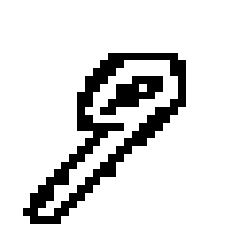

In [227]:
plt.imshow(a,cmap='gray')
plt.axis('off')
plt.show()

In [229]:
a_chain = get_chain_code_features(a)[0]
a_hinge = get_hinge_features1(a)
print(np.isfinite(a_chain).all(),np.isfinite(a_hinge).all())
print(a_chain.shape,a_hinge.shape)

(50,) (50,)
(18,)
[27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
(20,) (20,)
(15,)
[ 0  1  2  3  4  5 11 12 13 14 15 16 17 18 19]
True True
(72,) (66,)


MNIST 피처추출 후 로지스틱

In [139]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]

#train data는 만개만 사용
x_train = x_train[:10000]
y_train = y_train[:10000]

# One-hot 인코딩
y_train_oh = tf.keras.utils.to_categorical(y_train, 10)
y_test_oh = tf.keras.utils.to_categorical(y_test, 10)
y_val_oh = tf.keras.utils.to_categorical(y_val, 10)

x_train_feature = []
x_valid_feature = []
x_test_feature = []

y_train_oh_1 = []
y_val_oh_1 = []
y_test_oh_1 = []

y_train_1 = []
y_val_1 = []
y_test_1 = []

from_data = {'x_train' : x_train ,'x_val' : x_val ,'x_test':x_test}
to_data = {'x_train' : x_train_feature ,'x_val' : x_valid_feature ,'x_test':x_test_feature}

from_y_oh = {'x_train' : y_train_oh ,'x_val' : y_val_oh ,'x_test':y_test_oh}
from_y = {'x_train' : y_train ,'x_val' : y_val ,'x_test':y_test}

to_y_oh = {'x_train' : y_train_oh_1 ,'x_val' : y_val_oh_1 ,'x_test':y_test_oh_1}
to_y = {'x_train' : y_train_1 ,'x_val' : y_val_1 ,'x_test':y_test_1}

for mode in from_data:
    for i ,img in tqdm(enumerate(from_data[mode])):
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 3, 3)
        
        chain = get_chain_code_features(img)[0]
        hinge = get_hinge_features(img)
        if np.isfinite(chain).all()==True and np.isfinite(hinge).all()==True:
            feature = np.concatenate([chain,hinge], axis=0)
            to_data[mode].append(feature)
            
            to_y_oh[mode].append(from_y_oh[mode][i])
            to_y[mode].append(from_y[mode][i])
            
print(len(x_train_feature),len(x_valid_feature),len(x_test_feature))
print(len(y_train_1),len(y_val_1),len(y_test_1))
print(len(y_train_oh_1),len(y_val_oh_1),len(y_test_oh_1))

454it [00:02, 176.89it/s]C:\Users\minki\Desktop\손글씨\preprocess.py:50: RuntimeWarning: invalid value encountered in true_divide
  normalised_hist = hist / np.sum(hist)
10000it [00:52, 190.80it/s]
10000it [00:52, 190.10it/s]
10000it [00:52, 190.95it/s]

9971 9975 9958
9971 9975 9958
9971 9975 9958


In [140]:
from sklearn.preprocessing import StandardScaler
cs = StandardScaler()
x_train_feature = cs.fit_transform(x_train_feature)
x_valid_feature = cs.transform(x_valid_feature)
x_test_feature = cs.transform(x_test_feature)

In [151]:
y_train_oh_1= np.array(y_train_oh_1)
y_train_oh_1 = y_train_oh_1.reshape(-1,10)

y_val_oh_1= np.array(y_val_oh_1)
y_val_oh_1 = y_val_oh_1.reshape(-1,10)

y_test_oh_1= np.array(y_test_oh_1)
y_test_oh_1 = y_test_oh_1.reshape(-1,10)

In [152]:
#모델 생성
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=10, input_dim=138, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=0, mode='auto')
model.fit(x_train_feature, y_train_oh_1, batch_size=100, epochs=500, validation_data=(x_valid_feature, y_val_oh_1),callbacks=[early_stopping])
result = model.evaluate(x_test_feature, y_test_oh_1)
print("최종 예측 성공률(%): ", result[1]*100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                1390      
                                                                 
Total params: 1,390
Trainable params: 1,390
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
100/100 [==============================] - 3s 5ms/step - loss: 2.1141 - accuracy: 0.3001 - val_loss: 1.5194 - val_accuracy: 0.4851
Epoch 2/500
100/100 [==============================] - 0s 3ms/step - loss: 1.2524 - accuracy: 0.5890 - val_loss: 1.0787 - val_accuracy: 0.6566
Epoch 3/500
100/100 [==============================] - 0s 4ms/step - loss: 0.9542 - accuracy: 0.7094 - val_loss: 0.8836 - val_accuracy: 0.7359
Epoch 4/500
100/100 [==============================] - 0s 3ms/step - loss: 0.8057 - accuracy: 0.7656 - val_loss: 0.7766 - val_accuracy: 0.7719
Epoch 5/

결론 : MNIST같이 모양을 예측하는데도 특징 벡터가 잘 쓰인당  
마지막으로 svm테스트

svm : vector 추출

In [159]:
param_grid = {'kernel':['rbf'], 'C':[7,8,9,10,11], 
              'gamma':['auto','scale',0.0005,0.001,0.002]}

svm_clf = SVC(decision_function_shape="ovr")
grid = GridSearchCV(svm_clf, param_grid=param_grid,scoring = 'accuracy',verbose = 1,n_jobs =-1) 
grid.fit(x_train_feature[:1000], y_train_1[:1000])
print(grid.best_score_,grid.best_params_)
print(pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')[['rank_test_score','params','mean_test_score']][:5])

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  94 out of 125 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.3s finished


0.781 {'C': 9, 'gamma': 0.001, 'kernel': 'rbf'}
    rank_test_score                                      params  \
13                1   {'C': 9, 'gamma': 0.001, 'kernel': 'rbf'}   
8                 2   {'C': 8, 'gamma': 0.001, 'kernel': 'rbf'}   
4                 3   {'C': 7, 'gamma': 0.002, 'kernel': 'rbf'}   
3                 4   {'C': 7, 'gamma': 0.001, 'kernel': 'rbf'}   
23                5  {'C': 11, 'gamma': 0.001, 'kernel': 'rbf'}   

    mean_test_score  
13            0.781  
8             0.780  
4             0.777  
3             0.777  
23            0.775  


In [160]:
svm_pred = grid.best_estimator_.predict(x_valid_feature)
print('Accuracy:', accuracy_score(y_val_1, svm_pred)*100, '%')

Accuracy: 78.73684210526316 %


In [161]:
svm_pred = grid.best_estimator_.predict(x_test_feature)
print('Accuracy:', accuracy_score(y_test_1, svm_pred)*100, '%')

Accuracy: 78.89134364330187 %


svm : 이미지 (기존 방식)

In [162]:
from sklearn.preprocessing import StandardScaler
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

cs = StandardScaler()
x_train = cs.fit_transform(x_train)
x_val = cs.transform(x_val)
x_test = cs.transform(x_test)

param_grid = {'kernel':['rbf'], 'C':[10,20,30,50,70], 
              'gamma':['auto','scale',0.001,0.005,0.007,0.01,0.05]}

svm_clf = SVC(decision_function_shape="ovr")
grid = GridSearchCV(svm_clf, param_grid=param_grid,scoring = 'accuracy',verbose = 1,n_jobs =-1) 
grid.fit(x_train[:1000], y_train[:1000])
print(grid.best_score_,grid.best_params_)
print(pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')[['rank_test_score','params','mean_test_score']][:5])

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   14.0s finished


0.869 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
    rank_test_score                                      params  \
16                1  {'C': 30, 'gamma': 0.001, 'kernel': 'rbf'}   
2                 1  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}   
30                1  {'C': 70, 'gamma': 0.001, 'kernel': 'rbf'}   
23                1  {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}   
9                 1  {'C': 20, 'gamma': 0.001, 'kernel': 'rbf'}   

    mean_test_score  
16            0.869  
2             0.869  
30            0.869  
23            0.869  
9             0.869  


In [163]:
svm_pred = grid.best_estimator_.predict(x_val)
print('Accuracy:', accuracy_score(y_val, svm_pred)*100, '%')

Accuracy: 89.0 %


In [164]:
svm_pred = grid.best_estimator_.predict(x_test)
print('Accuracy:', accuracy_score(y_test, svm_pred)*100, '%')

Accuracy: 88.32 %
